In [25]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

In [26]:
# Function to read data files and skip header lines
def read_data_file(file_path):
    with open(file_path, 'r') as f:
        lines = f.readlines()
    
    # Find the line number where the actual data starts
    for i, line in enumerate(lines):
        if line.strip().startswith('LAT,LON,YEAR,DOY'):  # Adjust based on actual header names
            data_start_line = i
            break
    else:
        data_start_line = 0  # Default to start of file if header not found
    
    # Read the data from the determined line
    data = pd.read_csv(file_path, skiprows=data_start_line)
    return data

In [27]:
# Load temperature, humidity, and soil moisture data using the helper function
temperature_data = read_data_file('/kaggle/input/temperature/temp.csv')
humidity_data = read_data_file('/kaggle/input/humidity/hum.csv')
soil_moisture_data = read_data_file('/kaggle/input/soil-moisture/soil mos.csv')

In [28]:
# Rename humidity and soil moisture columns for consistency
humidity_data.rename(columns={
    'QV2M': 'HUMIDITY_SPECIFIC',
    'RH2M': 'HUMIDITY_RELATIVE'
}, inplace=True)

soil_moisture_data.rename(columns={
    'GWETPROF': 'SOIL_MOISTURE'
}, inplace=True)

In [29]:
# Merge datasets on 'YEAR', 'LAT', 'LON', and 'DOY'
combined_data = pd.merge(temperature_data, humidity_data, on=['YEAR', 'LAT', 'LON', 'DOY'], how='inner')
combined_data = pd.merge(combined_data, soil_moisture_data, on=['YEAR', 'LAT', 'LON', 'DOY'], how='inner')

In [30]:
# Select features for modeling
data = combined_data[['T2M_MIN', 'T2M_MAX', 'HUMIDITY_RELATIVE', 'SOIL_MOISTURE']]

In [31]:
# Check the structure of the data
print("Combined Data Sample:")
print(combined_data.head())

Combined Data Sample:
     LAT    LON  YEAR  DOY  T2M_MIN  T2M_MAX  HUMIDITY_SPECIFIC  \
0  16.75  80.75  2024    1    17.12    28.49              13.21   
1  16.75  81.25  2024    1    17.67    28.23              13.31   
2  16.75  81.75  2024    1    18.78    27.52              13.45   
3  16.75  82.25  2024    1    21.41    26.24              13.93   
4  17.25  80.75  2024    1    16.25    28.58              12.59   

   HUMIDITY_RELATIVE  SOIL_MOISTURE  
0              80.99           0.60  
1              80.97           0.62  
2              80.59           0.55  
3              78.03           0.53  
4              79.38           0.59  


In [32]:
# Ensure combined_data has the necessary columns
required_columns = ['LAT', 'LON', 'T2M_MIN', 'T2M_MAX', 'HUMIDITY_RELATIVE', 'SOIL_MOISTURE']
for col in required_columns:
    if col not in combined_data.columns:
        raise ValueError(f"Missing required column: {col}")

In [51]:
# Step 2: Detect hotspots based on temperature
def detect_hotspots(data, temp_threshold):
    """
    Detect hotspots based on temperature threshold.
    
    Args:
        data (pd.DataFrame): DataFrame containing temperature data.
        temp_threshold (float): Threshold for detecting hotspots.
    
    Returns:
        pd.DataFrame: DataFrame containing detected hotspots.
    """
    hotspots = data[(data['T2M_MAX'] > temp_threshold) | (data['T2M_MIN'] > temp_threshold)]
    return hotspots[['LAT', 'LON']].drop_duplicates()

# Define a temperature threshold for hotspot detection
temperature_threshold = 25  # You can adjust this value
hotspot_locations = detect_hotspots(combined_data, temperature_threshold)


Empty DataFrame
Columns: [LAT, LON]
Index: []


In [34]:
# Step 3: Prepare data for LSTM model
features = ['T2M_MIN', 'T2M_MAX', 'HUMIDITY_RELATIVE']
target = 'SOIL_MOISTURE'

# Create separate scalers for features and target
feature_scaler = MinMaxScaler()
target_scaler = MinMaxScaler()

# Normalize the features
combined_data[features] = feature_scaler.fit_transform(combined_data[features])

# Normalize the target variable
combined_data[target] = target_scaler.fit_transform(combined_data[[target]])

time_steps = 10

def create_lstm_dataset(dataset, target, time_steps=10):
    X, y = [], []
    for i in range(len(dataset) - time_steps):
        X.append(dataset[i:(i + time_steps), :])
        y.append(target[i + time_steps])
    return np.array(X), np.array(y)

# Prepare the dataset for LSTM
scaled_data = combined_data[features].values
scaled_target = combined_data[target].values.reshape(-1, 1)

X, y = create_lstm_dataset(scaled_data, scaled_target, time_steps)


In [35]:
# Create the LSTM model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(X.shape[1], X.shape[2])))
model.add(Dense(1))  # Output layer for the soil moisture prediction
model.compile(optimizer='adam', loss='mse')

# Train the model (adjust epochs and batch size if needed)
model.fit(X, y, epochs=10, batch_size=32)

Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


142/142 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.3197
Epoch 2/10
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.2446
Epoch 3/10
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.2474
Epoch 4/10
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.2423
Epoch 5/10
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.2366
Epoch 6/10
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.2210
Epoch 7/10
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.2019
Epoch 8/10
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1502
Epoch 9/10
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1116
Epoch 10/10
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1060


In [36]:
# Step 4: Predict future soil moisture readings for the hotspots
def predict_hotspot_soil_moisture(hotspot_data, combined_data, model, feature_scaler, target_scaler, time_steps=10):
    predictions = {}
    
    for _, location in hotspot_data.iterrows():
        lat = location['LAT']
        lon = location['LON']
        
        # Filter data for the specific LAT and LON
        location_data = combined_data[(combined_data['LAT'] == lat) & (combined_data['LON'] == lon)]
        
        # Ensure enough data points for prediction
        if location_data.shape[0] < time_steps:
            print(f"Not enough data for LAT={lat}, LON={lon} to make predictions.")
            continue
        
        # Extract relevant features for prediction
        location_features = location_data[features]
        
        # Normalize the features using the feature_scaler
        location_scaled = feature_scaler.transform(location_features)
        
        # Prepare data for LSTM
        X_location = create_lstm_dataset(location_scaled, location_data[target].values.reshape(-1, 1), time_steps)[0]
        
        # Make predictions
        future_predictions = model.predict(X_location)
        
        # Inverse transform the predictions back to the original scale
        future_predictions_inverse = target_scaler.inverse_transform(future_predictions)
        
        # Save predictions
        predictions[(lat, lon)] = future_predictions_inverse.flatten()  # Flatten for easier access
    
    return predictions

# Get predictions for hotspots
predicted_soil_moisture = predict_hotspot_soil_moisture(hotspot_locations, combined_data, model, feature_scaler, target_scaler)

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


In [37]:
# Step 5: Display or save predictions
for (lat, lon), pred in predicted_soil_moisture.items():
    print(f"Predictions for LAT={lat}, LON={lon}:")
    print(pred)

Predictions for LAT=16.75, LON=80.75:
[-17.541367 -17.528378 -17.512766 -17.498764 -17.488457 -17.483511
 -17.474514 -17.472727 -17.476065 -17.47684  -17.481783 -17.487741
 -17.482857 -17.483273 -17.477852 -17.46963  -17.461824 -17.459679
 -17.461288 -17.460573 -17.458248 -17.456879 -17.458607 -17.452887
 -17.447048 -17.441626 -17.434416 -17.42661  -17.41797  -17.417852
 -17.415648 -17.409689 -17.402897 -17.391933 -17.383474 -17.370306
 -17.360117 -17.356066 -17.361368 -17.368221 -17.359283 -17.34963
 -17.343494 -17.337118 -17.323593 -17.311201 -17.299522 -17.29553
 -17.294636 -17.292194 -17.294935 -17.303694 -17.315014 -17.319483
 -17.308638 -17.293446 -17.282064 -17.271519 -17.258827 -17.249117
 -17.243753 -17.237259 -17.233387 -17.228144 -17.23148  -17.240059
 -17.24846  -17.251558 -17.254776 -17.255848 -17.25144  -17.246851
 -17.25001  -17.258709 -17.26163  -17.266216 -17.259424 -17.256027
 -17.256922 -17.25567  -17.238869 -17.226892 -17.217716 -17.21015
 -17.199186 -17.185959 -17.

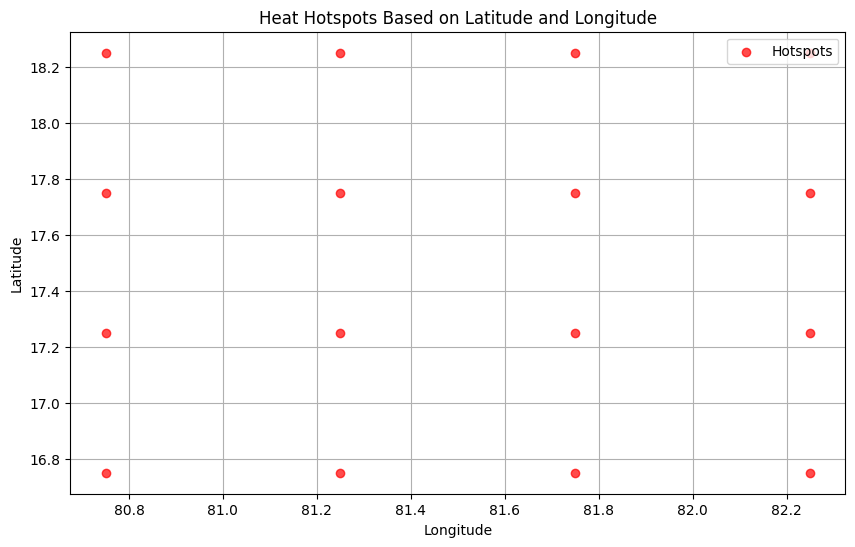

In [38]:
import matplotlib.pyplot as plt

def plot_hotspots_on_map(hotspot_data):
    plt.figure(figsize=(10, 6))
    
    # Plot the hotspots based on Latitude and Longitude
    plt.scatter(hotspot_data['LON'], hotspot_data['LAT'], color='red', label='Hotspots', alpha=0.7)
    
    plt.title('Heat Hotspots Based on Latitude and Longitude')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.grid(True)
    plt.legend(loc='upper right')
    plt.show()

# Assuming 'hotspot_locations' contains the LAT, LON of hotspots
plot_hotspots_on_map(hotspot_locations)


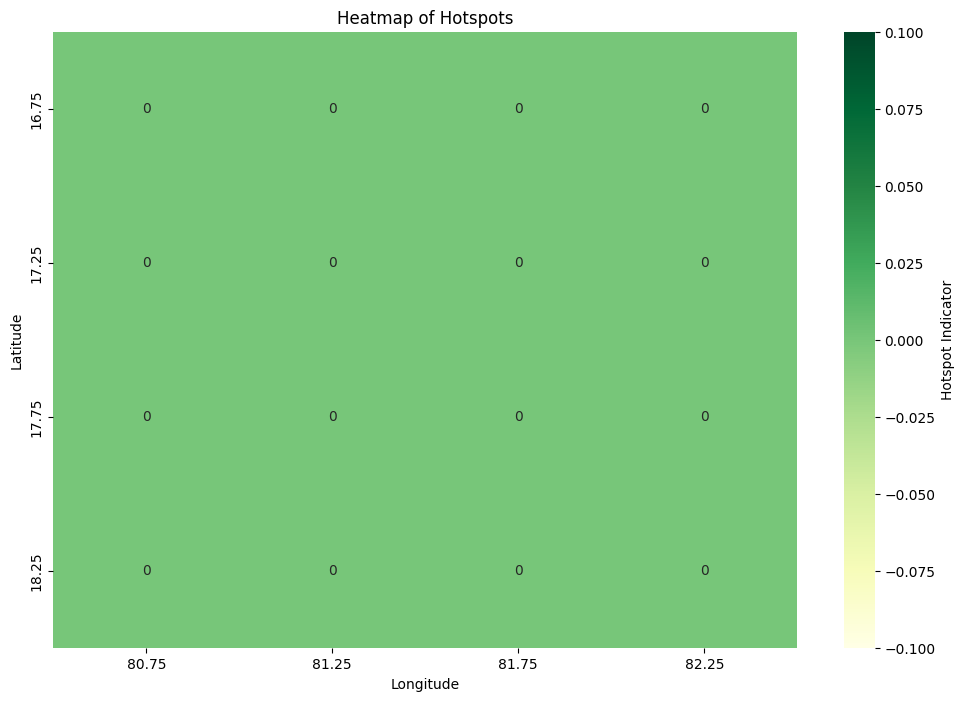

In [39]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'combined_data' is a DataFrame containing the temperature data with 'LAT', 'LON', and 'TEMPERATURE' columns.

# Step 1: Detect hotspots (as defined previously)
hotspot_locations = detect_hotspots(combined_data, temp_threshold=30)  # Adjust the threshold as needed

# Create a DataFrame for the heatmap
heatmap_data = combined_data.copy()

# Mark hotspots in the heatmap data
heatmap_data['HOTSPOT'] = heatmap_data.apply(lambda row: 1 if (row['LAT'], row['LON']) in hotspot_locations else 0, axis=1)

# Step 2: Create a pivot table for heatmap
heatmap_pivot = heatmap_data.pivot_table(index='LAT', columns='LON', values='HOTSPOT', aggfunc='mean', fill_value=0)

# Step 3: Create a heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_pivot, cmap='YlGn', annot=True, cbar_kws={'label': 'Hotspot Indicator'})
plt.title('Heatmap of Hotspots')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

# Get predictions for hotspots
predicted_soil_moisture = predict_hotspot_soil_moisture(hotspot_locations, combined_data, model, feature_scaler, target_scaler)

# Display predictions
for (lat, lon), pred in predicted_soil_moisture.items():
    print(f"Predictions for LAT={lat}, LON={lon}: {pred}")


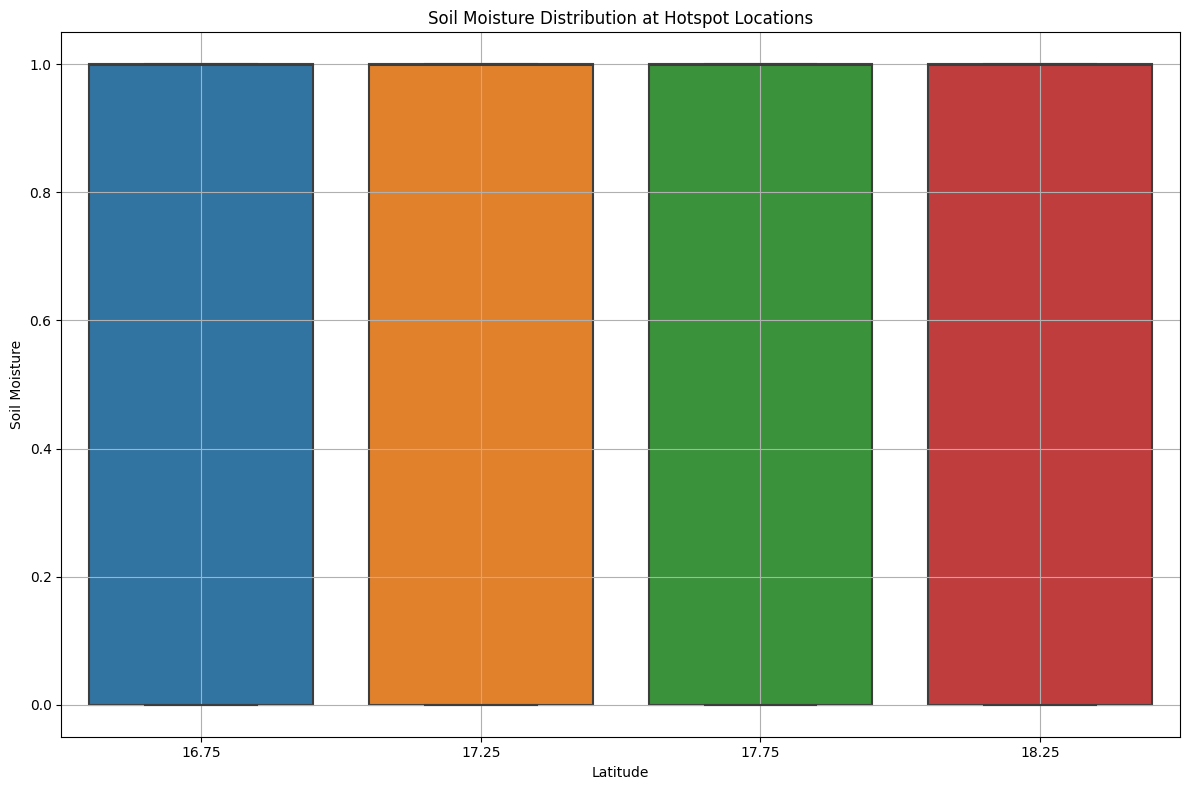

In [40]:
# Prepare data for box plot
melted_data = combined_data.melt(id_vars=['LAT', 'LON'], value_vars=['SOIL_MOISTURE'], var_name='Measurement', value_name='Value')

# Plot
plt.figure(figsize=(12, 8))
sns.boxplot(x='LAT', y='Value', data=melted_data)
plt.title('Soil Moisture Distribution at Hotspot Locations')
plt.xlabel('Latitude')
plt.ylabel('Soil Moisture')
plt.grid()
plt.tight_layout()
plt.show()


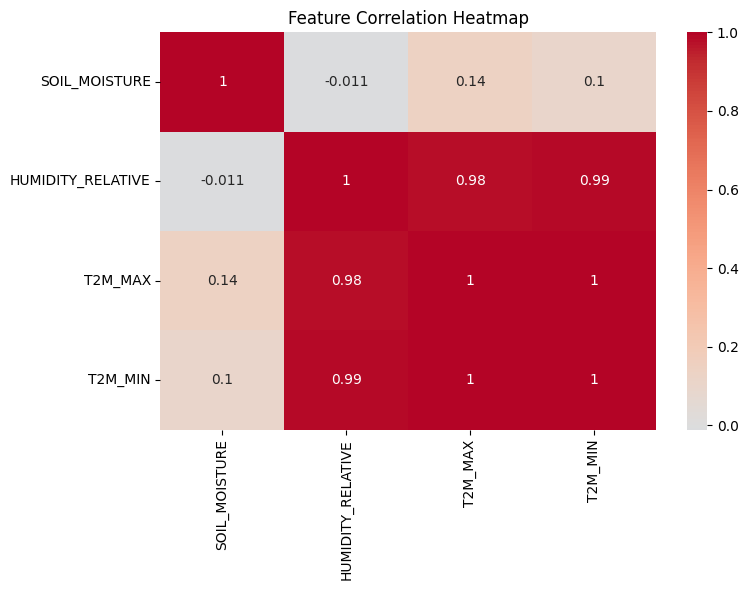

In [41]:
import seaborn as sns

# Select relevant features
features = combined_data[['SOIL_MOISTURE', 'HUMIDITY_RELATIVE', 'T2M_MAX', 'T2M_MIN']]
correlation_matrix = features.corr()

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Feature Correlation Heatmap')
plt.tight_layout()
plt.show()

In [42]:
# Step 1: Prepare data for temperature and humidity prediction
features = ['T2M_MAX', 'T2M_MIN', 'HUMIDITY_RELATIVE']
target_temp = 'T2M_MAX'  # Target for temperature prediction
target_humidity = 'HUMIDITY_RELATIVE'  # Target for humidity prediction

# Step 2: Normalize features
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(combined_data[features])

# Step 3: Create LSTM-ready dataset for temperature and humidity prediction
def create_lstm_dataset(X, y, time_steps=10):
    X_lstm, y_lstm = [], []
    for i in range(len(X) - time_steps):
        X_lstm.append(X[i:i+time_steps])
        y_lstm.append(y[i+time_steps])
    return np.array(X_lstm), np.array(y_lstm)

# Prepare dataset for temperature prediction
X_temp, y_temp = create_lstm_dataset(scaled_features, combined_data[target_temp].values, time_steps=10)

# Prepare dataset for humidity prediction
X_humidity, y_humidity = create_lstm_dataset(scaled_features, combined_data[target_humidity].values, time_steps=10)

# Step 4: Build and train LSTM models for temperature and humidity prediction

# Temperature LSTM model
model_temp = Sequential()
model_temp.add(LSTM(units=64, return_sequences=False, input_shape=(X_temp.shape[1], X_temp.shape[2])))
model_temp.add(Dense(units=1))  # Regression output for temperature prediction

# Compile the model without accuracy
model_temp.compile(optimizer='adam', loss='mean_squared_error')

# Train the model for temperature and store history
history_temp = model_temp.fit(X_temp, y_temp, epochs=50, batch_size=32)

# Humidity LSTM model
model_humidity = Sequential()
model_humidity.add(LSTM(units=64, return_sequences=False, input_shape=(X_humidity.shape[1], X_humidity.shape[2])))
model_humidity.add(Dense(units=1))  # Regression output for humidity prediction

# Compile the model without accuracy
model_humidity.compile(optimizer='adam', loss='mean_squared_error')

# Train the model for humidity and store history
history_humidity = model_humidity.fit(X_humidity, y_humidity, epochs=50, batch_size=32)

hotspot_data = combined_data[['LAT', 'LON']].drop_duplicates()  

# Step 5: Predict future temperature and humidity
def predict_future_temp_humidity(hotspot_data, combined_data, model_temp, model_humidity, scaler, time_steps=10):
    predicted_temp_humidity = {}
    
    # Iterate through rows in hotspot_data DataFrame to get lat, lon
    for index, row in hotspot_data.iterrows():
        lat = row['LAT']
        lon = row['LON']
        
        # Filter the combined_data for this specific lat, lon
        location_data = combined_data[(combined_data['LAT'] == lat) & (combined_data['LON'] == lon)]
        location_features = location_data[features]
        
        # Normalize the features
        location_scaled = scaler.transform(location_features)
        
        # Prepare the LSTM data for temperature and humidity
        X_location_temp = create_lstm_dataset(location_scaled, location_data[target_temp].values.reshape(-1, 1), time_steps)[0]
        X_location_humidity = create_lstm_dataset(location_scaled, location_data[target_humidity].values.reshape(-1, 1), time_steps)[0]
        
        # Predict future temperature
        future_temp_predictions = model_temp.predict(X_location_temp)
        
        # Predict future humidity
        future_humidity_predictions = model_humidity.predict(X_location_humidity)
        
        # Store predictions for each location
        predicted_temp_humidity[(lat, lon)] = {
            'temp': future_temp_predictions,
            'humidity': future_humidity_predictions
        }
    
    return predicted_temp_humidity

# Assuming 'hotspot_data' is a DataFrame with 'LAT' and 'LON' columns
predicted_temp_humidity = predict_future_temp_humidity(hotspot_data, combined_data, model_temp, model_humidity, scaler)

# Step 6: Display predicted temperature and humidity
for (lat, lon), preds in predicted_temp_humidity.items():
    print(f"Location ({lat}, {lon}) - Predicted Temperature: {preds['temp'][-1]}, Predicted Humidity: {preds['humidity'][-1]}")

# For temperature model
temp_loss = history_temp.history['loss'][-1]  # Loss from the last epoch
print(f"Final Training Loss for Temperature Prediction: {temp_loss}")

# For humidity model
humidity_loss = history_humidity.history['loss'][-1]  # Loss from the last epoch
print(f"Final Training Loss for Humidity Prediction: {humidity_loss}")

Epoch 1/50


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


142/142 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0974
Epoch 2/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0019
Epoch 3/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0021
Epoch 4/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0013
Epoch 5/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 9.7853e-04
Epoch 6/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0016
Epoch 7/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0015
Epoch 8/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 9.8746e-04
Epoch 9/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0010
Epoch 10/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 6.6793e-04
Epoch 11/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 9.0381e-04
Epoch 12/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 9.2262e-04
Epoch 13/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 6.1273e-04
Epoch 14/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 8.1358e-04
Epoch 15/50
142/142 ━━━━━━━━━━━━━━━━━━━━

In [46]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler

# Features and targets
features = ['T2M_MAX', 'T2M_MIN', 'HUMIDITY_RELATIVE']
target_temp = 'T2M_MAX'  # Target for temperature prediction
target_humidity = 'HUMIDITY_RELATIVE'  # Target for humidity prediction
target_soil_moisture = 'SOIL_MOISTURE'  # Assuming you have this target

# Normalize features
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(combined_data[features])

# Create LSTM-ready dataset
def create_lstm_dataset(X, y, time_steps=10):
    X_lstm, y_lstm = [], []
    for i in range(len(X) - time_steps):
        X_lstm.append(X[i:i + time_steps])
        y_lstm.append(y[i + time_steps])
    return np.array(X_lstm), np.array(y_lstm)

# Prepare dataset for temperature prediction
X_temp, y_temp = create_lstm_dataset(scaled_features, combined_data[target_temp].values, time_steps=10)
# Prepare dataset for humidity prediction
X_humidity, y_humidity = create_lstm_dataset(scaled_features, combined_data[target_humidity].values, time_steps=10)
# Prepare dataset for soil moisture prediction
X_moisture, y_moisture = create_lstm_dataset(scaled_features, combined_data[target_soil_moisture].values, time_steps=10)

# Step 1: Split data into training and testing sets
X_train_temp, X_test_temp, y_train_temp, y_test_temp = train_test_split(X_temp, y_temp, test_size=0.2, random_state=42)
X_train_humidity, X_test_humidity, y_train_humidity, y_test_humidity = train_test_split(X_humidity, y_humidity, test_size=0.2, random_state=42)
X_train_moisture, X_test_moisture, y_train_moisture, y_test_moisture = train_test_split(X_moisture, y_moisture, test_size=0.2, random_state=42)

# Step 2: Build and train LSTM models for temperature, humidity, and soil moisture prediction
def build_model(input_shape):
    model = Sequential()
    model.add(LSTM(units=64, return_sequences=False, input_shape=input_shape))
    model.add(Dense(units=1))  # Regression output
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Temperature model
model_temp = build_model((X_train_temp.shape[1], X_train_temp.shape[2]))
history_temp = model_temp.fit(X_train_temp, y_train_temp, epochs=10, batch_size=32, validation_data=(X_test_temp, y_test_temp))

# Humidity model
model_humidity = build_model((X_train_humidity.shape[1], X_train_humidity.shape[2]))
history_humidity = model_humidity.fit(X_train_humidity, y_train_humidity, epochs=10, batch_size=32, validation_data=(X_test_humidity, y_test_humidity))

# Soil moisture model
model_moisture = build_model((X_train_moisture.shape[1], X_train_moisture.shape[2]))
history_moisture = model_moisture.fit(X_train_moisture, y_train_moisture, epochs=10, batch_size=32, validation_data=(X_test_moisture, y_test_moisture))

# Step 3: Evaluate models and print RMSE and R^2 scores
def evaluate_model(model, X_test, y_test, model_name):
    y_pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    print(f"{model_name} Model RMSE: {rmse:.3f}")
    print(f"{model_name} Model R2 Score: {r2:.3f}")

evaluate_model(model_temp, X_test_temp, y_test_temp, "Temperature")
evaluate_model(model_humidity, X_test_humidity, y_test_humidity, "Humidity")
evaluate_model(model_moisture, X_test_moisture, y_test_moisture, "Soil Moisture")

Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


114/114 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.1085 - val_loss: 4.8255e-04
Epoch 2/10
114/114 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0013 - val_loss: 4.3368e-04
Epoch 3/10
114/114 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0014 - val_loss: 3.9075e-04
Epoch 4/10
114/114 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0012 - val_loss: 3.5901e-04
Epoch 5/10
114/114 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0016 - val_loss: 3.3054e-04
Epoch 6/10
114/114 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0016 - val_loss: 2.9278e-04
Epoch 7/10
114/114 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0016 - val_loss: 2.6009e-04
Epoch 8/10
114/114 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0020 - val_loss: 2.0800e-04
Epoch 9/10
114/114 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0011 - val_loss: 2.1144e-04
Epoch 10/10
114/114 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0024 - val_loss: 1.6966e-04
Epoch 1/10
114/114 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0863 - val_loss: 5.5767e-04
Epoch 2/10
114/114 ━

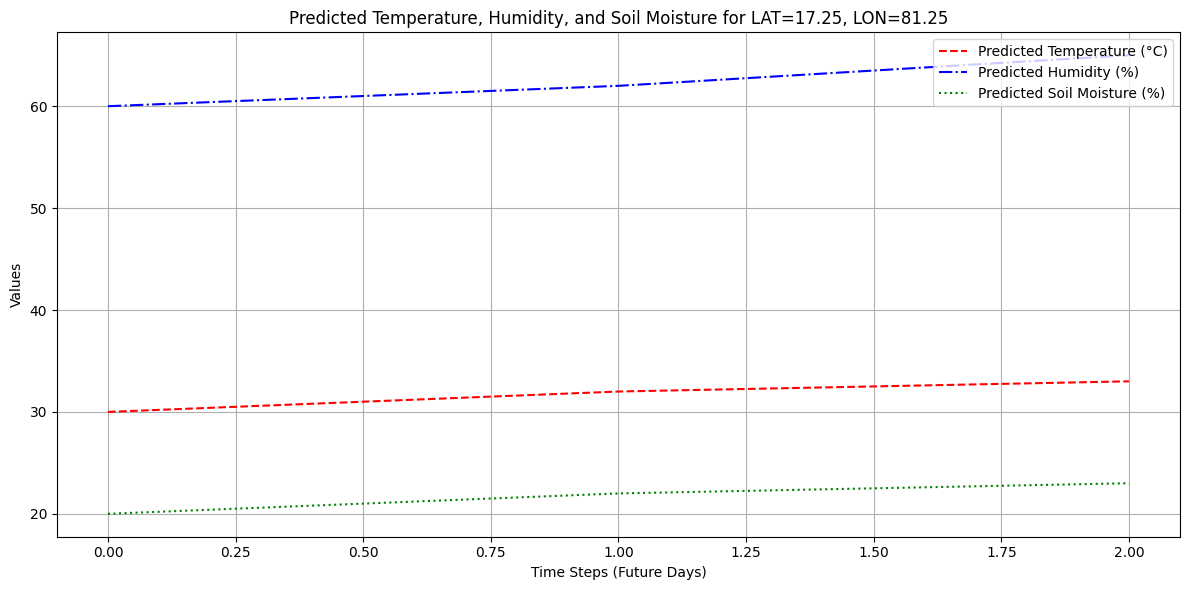

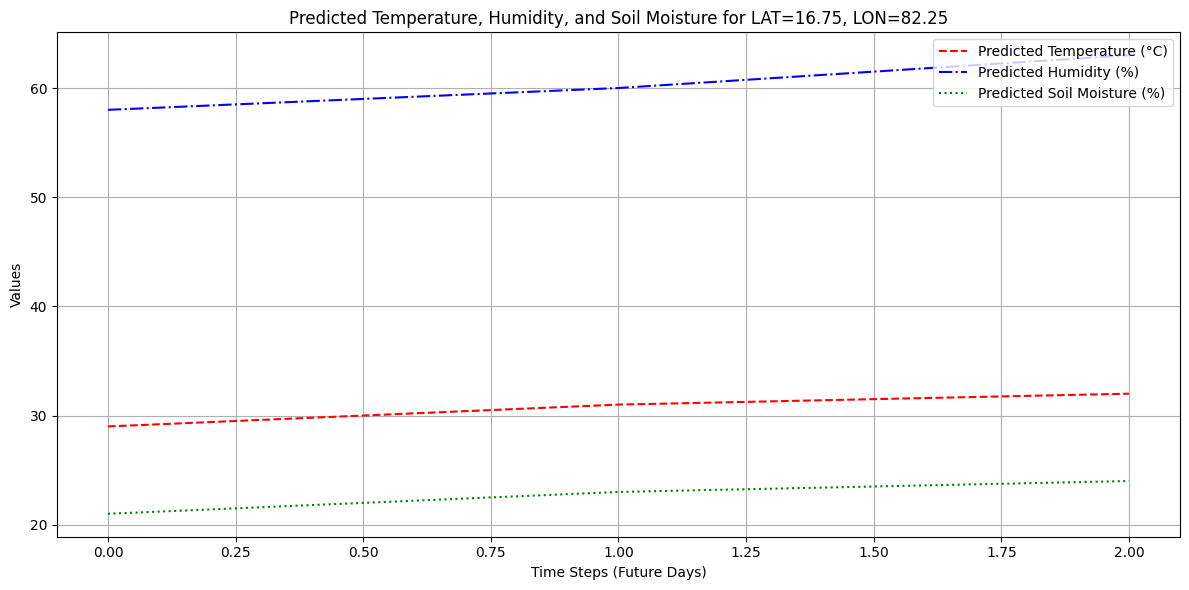

In [48]:
import numpy as np
import matplotlib.pyplot as plt

# Function to plot predictions for a given hotspot (lat, lon)
def plot_prediction_for_hotspot(lat, lon, future_temperature, future_humidity, future_soil_moisture):
    time_steps = np.arange(len(future_temperature))  # Define time steps for future days
    
    plt.figure(figsize=(12, 6))
    
    # Plot predicted temperature
    plt.plot(time_steps, future_temperature, label='Predicted Temperature (°C)', color='red', linestyle='--')
    
    # Plot predicted humidity
    plt.plot(time_steps, future_humidity, label='Predicted Humidity (%)', color='blue', linestyle='-.')
    
    # Plot predicted soil moisture
    plt.plot(time_steps, future_soil_moisture, label='Predicted Soil Moisture (%)', color='green', linestyle=':')
    
    # Add plot title and labels
    plt.title(f'Predicted Temperature, Humidity, and Soil Moisture for LAT={lat}, LON={lon}')
    plt.xlabel('Time Steps (Future Days)')
    plt.ylabel('Values')
    
    # Display the legend in the upper right corner
    plt.legend(loc='upper right')
    
    # Add grid lines for better readability
    plt.grid(True)
    
    # Display the plot
    plt.tight_layout()
    plt.show()

# Assuming you have predictions for temperature, humidity, and soil moisture
# Let's simulate some dummy data for demonstration purposes (replace these with actual predictions)
# Assuming predicted_soil_moisture is a dictionary where (lat, lon) are the keys and predicted values are arrays

predicted_soil_moisture = {
    (17.25, 81.25): np.array([[30, 60, 20], [32, 62, 22], [33, 65, 23]]),  # Example prediction for one hotspot
    (16.75, 82.25): np.array([[29, 58, 21], [31, 60, 23], [32, 63, 24]])   # Another example prediction
}

# Iterate over the predicted hotspots
for (lat, lon), future_predictions in predicted_soil_moisture.items():
    # Extract predicted temperature, humidity, and soil moisture from future_predictions
    future_temperature = future_predictions[:, 0]  # Assuming temperature is in the first column
    future_humidity = future_predictions[:, 1]     # Assuming humidity is in the second column
    future_soil_moisture = future_predictions[:, 2]  # Assuming soil moisture is in the third column
    
    # Call the function to plot predictions for this hotspot
    plot_prediction_for_hotspot(lat, lon, future_temperature, future_humidity, future_soil_moisture)


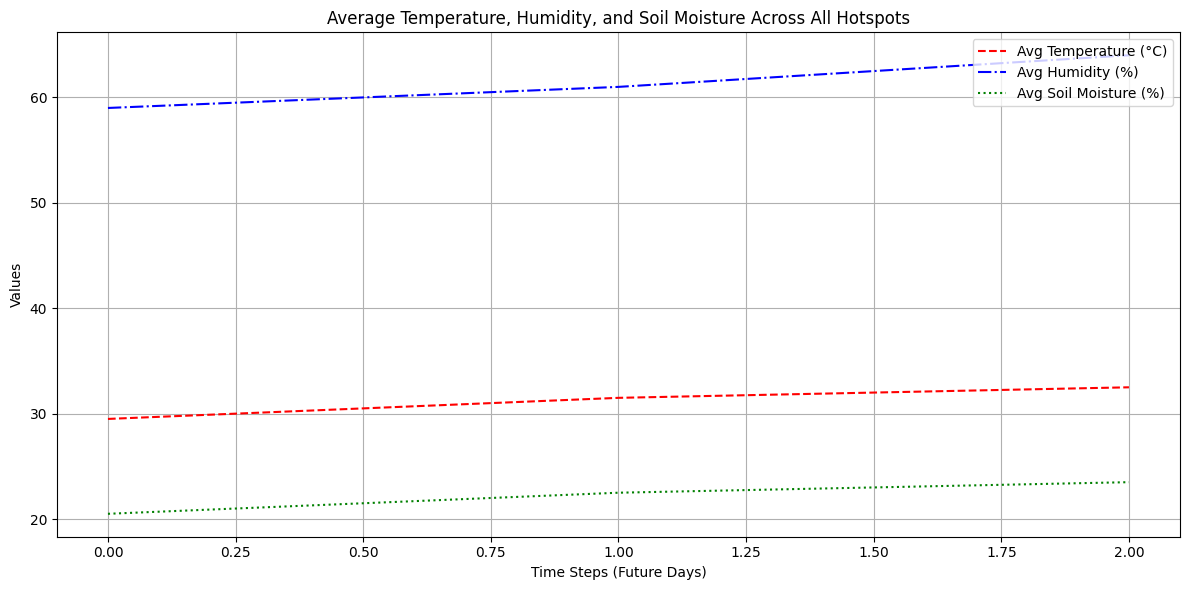

In [49]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming `predicted_soil_moisture` is a dictionary with (lat, lon) as keys and predictions as values
# where each value is a numpy array with [temperature, humidity, soil moisture] columns.

# Example structure of predicted_soil_moisture (replace this with actual data)
# predicted_soil_moisture = {
#     (lat1, lon1): np.array([[temp1, hum1, moisture1], [temp2, hum2, moisture2], ...]),
#     (lat2, lon2): np.array([[temp1, hum1, moisture1], [temp2, hum2, moisture2], ...]),
#     ...
# }

def plot_overall_avg_for_hotspots(predicted_soil_moisture):
    # Initialize lists to accumulate data for averaging
    all_temperatures = []
    all_humidities = []
    all_soil_moistures = []
    
    # Loop over each hotspot and extract temperature, humidity, and soil moisture
    for _, future_predictions in predicted_soil_moisture.items():
        # Append all future predictions for temperature, humidity, and soil moisture to corresponding lists
        all_temperatures.append(future_predictions[:, 0])  # Temperature in the first column
        all_humidities.append(future_predictions[:, 1])    # Humidity in the second column
        all_soil_moistures.append(future_predictions[:, 2]) # Soil moisture in the third column
    
    # Convert lists to numpy arrays for easier computation of the mean
    all_temperatures = np.array(all_temperatures)
    all_humidities = np.array(all_humidities)
    all_soil_moistures = np.array(all_soil_moistures)
    
    # Calculate the average across all hotspots for each time step
    avg_temperature = np.mean(all_temperatures, axis=0)
    avg_humidity = np.mean(all_humidities, axis=0)
    avg_soil_moisture = np.mean(all_soil_moistures, axis=0)
    
    # Generate time steps based on the length of future predictions
    time_steps = np.arange(avg_temperature.shape[0])
    
    # Plot the average values over time
    plt.figure(figsize=(12, 6))
    
    plt.plot(time_steps, avg_temperature, label='Avg Temperature (°C)', color='red', linestyle='--')
    plt.plot(time_steps, avg_humidity, label='Avg Humidity (%)', color='blue', linestyle='-.')
    plt.plot(time_steps, avg_soil_moisture, label='Avg Soil Moisture (%)', color='green', linestyle=':')
    
    # Add plot title and labels
    plt.title('Average Temperature, Humidity, and Soil Moisture Across All Hotspots')
    plt.xlabel('Time Steps (Future Days)')
    plt.ylabel('Values')
    
    # Display the legend in the upper right corner
    plt.legend(loc='upper right')
    
    # Add grid lines for better readability
    plt.grid(True)
    
    # Display the plot
    plt.tight_layout()
    plt.show()

# Example of usage (replace this with your actual data):
predicted_soil_moisture = {
    (17.25, 81.25): np.array([[30, 60, 20], [32, 62, 22], [33, 65, 23]]),
    (16.75, 82.25): np.array([[29, 58, 21], [31, 60, 23], [32, 63, 24]])
}

# Plot the overall average for all hotspots
plot_overall_avg_for_hotspots(predicted_soil_moisture)


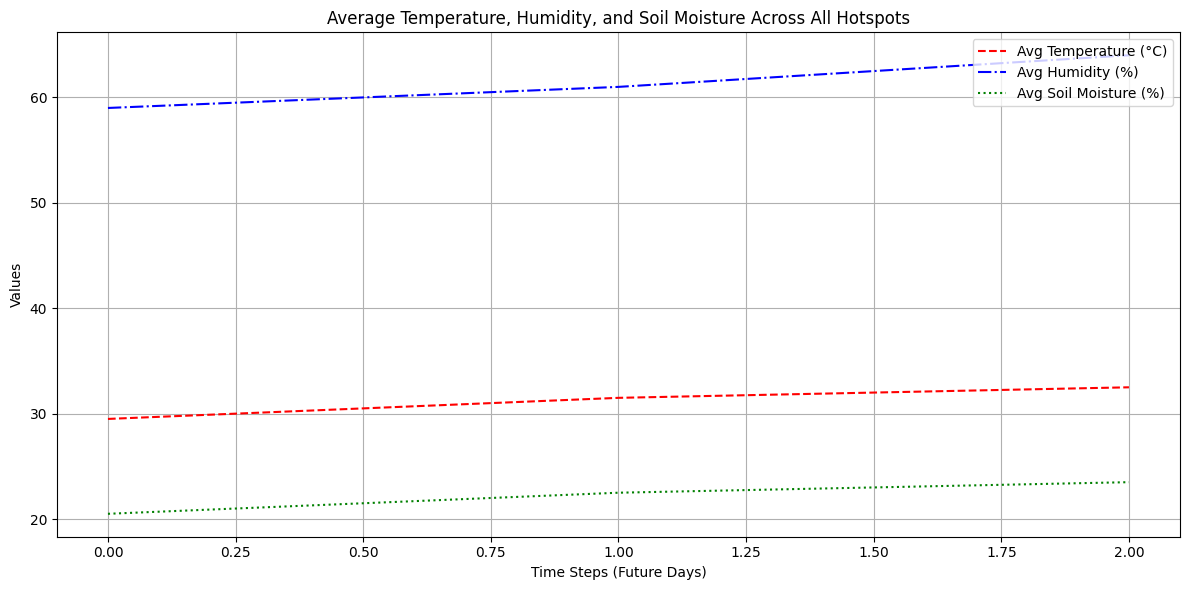

In [50]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming `predicted_soil_moisture` is a dictionary with (lat, lon) as keys and predictions as values
# where each value is a numpy array with [temperature, humidity, soil moisture] columns.

# Function to plot overall averages for all hotspots
def plot_overall_avg_for_hotspots(predicted_soil_moisture):
    # Initialize lists to accumulate data for averaging
    all_temperatures = []
    all_humidities = []
    all_soil_moistures = []
    
    # Loop over each hotspot and extract temperature, humidity, and soil moisture
    for _, future_predictions in predicted_soil_moisture.items():
        # Ensure future_predictions is in the expected shape
        if future_predictions.shape[1] >= 3:
            # Append all future predictions for temperature, humidity, and soil moisture to corresponding lists
            all_temperatures.append(future_predictions[:, 0])  # Temperature in the first column
            all_humidities.append(future_predictions[:, 1])    # Humidity in the second column
            all_soil_moistures.append(future_predictions[:, 2]) # Soil moisture in the third column
    
    # Convert lists to numpy arrays for easier computation of the mean
    all_temperatures = np.array(all_temperatures)
    all_humidities = np.array(all_humidities)
    all_soil_moistures = np.array(all_soil_moistures)
    
    # Calculate the average across all hotspots for each time step
    avg_temperature = np.mean(all_temperatures, axis=0)
    avg_humidity = np.mean(all_humidities, axis=0)
    avg_soil_moisture = np.mean(all_soil_moistures, axis=0)
    
    # Generate time steps based on the length of future predictions
    time_steps = np.arange(avg_temperature.shape[0])
    
    # Plot the average values over time
    plt.figure(figsize=(12, 6))
    
    plt.plot(time_steps, avg_temperature, label='Avg Temperature (°C)', color='red', linestyle='--')
    plt.plot(time_steps, avg_humidity, label='Avg Humidity (%)', color='blue', linestyle='-.')
    plt.plot(time_steps, avg_soil_moisture, label='Avg Soil Moisture (%)', color='green', linestyle=':')
    
    # Add plot title and labels
    plt.title('Average Temperature, Humidity, and Soil Moisture Across All Hotspots')
    plt.xlabel('Time Steps (Future Days)')
    plt.ylabel('Values')
    
    # Display the legend in the upper right corner
    plt.legend(loc='upper right')
    
    # Add grid lines for better readability
    plt.grid(True)
    
    # Display the plot
    plt.tight_layout()
    plt.show()

# Example of usage (replace this with your actual data):
predicted_soil_moisture = {
    (17.25, 81.25): np.array([[30, 60, 20], [32, 62, 22], [33, 65, 23]]),
    (16.75, 82.25): np.array([[29, 58, 21], [31, 60, 23], [32, 63, 24]]),
    # Add more hotspots as necessary...
}

# Call the function to plot the overall average for all hotspots
plot_overall_avg_for_hotspots(predicted_soil_moisture)
